In [1]:
import torch_geometric
from torch_geometric.datasets import QM9

/cluster/project/krause/bsoyuer/miniconda3/envs/graphbo/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = QM9(root="../../data/QM9")

MAX_NUM_NODES = 29

In [3]:
print(dataset) #QM9
print(len(dataset)) #130831 this many graphs
print(dataset.num_node_features) #11
print(dataset.num_classes) #19 continous labels
print(dataset.num_edge_features) #4 - we probably will discard for graphbo
print(dataset.num_features) #11

print(dataset.data) #The graph adjacency is represented through edge_index: 2xnum_all_valid_edges_in_each_molecule
#Note that to account for direction of edges, each edge is written twice by swapping source and target node.
#When transposed' it simply gives pairs of nodes as rows for each edge (there is two permuted rows for each edge)
#x is the features matrix concatenated in form

print(type(dataset.data.x))
#rint(dataset.data.x[130830,:])
index = 0
print(dataset[index]) #This is the CH4 molecule so there are 5 nodes and 4 edges (8 total for edge index)
print(dataset[index].edge_index) #NOTE: NOT NECESSARILY SYMMETYRIC WRT PARIS!!!!
print(dataset[index].y[0,0]) #This is dipole moment mu from Oxford Paper
print("\n")
print(dataset[dataset.data.idx[0]])
print(len(dataset.data.idx))

print(dataset[index].pos)
print('y:',dataset[index].y)

import numpy as np
import sys
np.set_printoptions(threshold=np.inf)
print(dataset[index].edge_attr)

QM9(130831)
130831
11
19
4
11
Data(x=[2359210, 11], edge_index=[2, 4883516], edge_attr=[4883516, 4], y=[130831, 19], pos=[2359210, 3], z=[2359210], name=[130831], idx=[130831])
<class 'torch.Tensor'>
Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], z=[5], name='gdb_1', idx=[1])
tensor([[0, 0, 0, 0, 1, 2, 3, 4],
        [1, 2, 3, 4, 0, 0, 0, 0]])
tensor(0.)


Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], z=[5], name='gdb_1', idx=[1])
130831
tensor([[-1.2700e-02,  1.0858e+00,  8.0000e-03],
        [ 2.2000e-03, -6.0000e-03,  2.0000e-03],
        [ 1.0117e+00,  1.4638e+00,  3.0000e-04],
        [-5.4080e-01,  1.4475e+00, -8.7660e-01],
        [-5.2380e-01,  1.4379e+00,  9.0640e-01]])
y: tensor([[    0.0000,    13.2100,   -10.5499,     3.1865,    13.7363,    35.3641,
             1.2177, -1101.4878, -1101.4098, -1101.3840, -1102.0229,     6.4690,
           -17.1722,   -17.2868,   -17.3897,   -16.1519,   157.7118,   157.7100,
       

In [4]:
import torch

#Try removing duplicates from edge index - NOT NECESSARY!!!!
# edge_index_list = torch.transpose(dataset[0].edge_index,0,1).tolist()
# print(edge_index_list)
# output = list(set((map(lambda x: tuple(sorted(x)),edge_index_list))))
# print(output)
# output_tensor = torch.tensor(output)
# #output_tensor = torch.tensor([torch.tensor(o) for o in output])
# print(output_tensor)
# #print(type(output[0]))

index = 6
edge_index_tensor = torch.transpose(dataset[index].edge_index,0,1)
num_nodes = dataset[index].z.shape[0]
#print(len(dataset[index].z))

#Try converting unique pairs of nodes connected to adj graph
def convert_to_adj(pairs, num_nodes):

    zero = torch.zeros(num_nodes, num_nodes)
    zero[pairs[:,0], pairs[:,1]] = 1 
    

    return zero


print(convert_to_adj(edge_index_tensor, num_nodes))


tensor([[0., 1., 1., 1., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 1., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.]])


COMPUTE CORRELATIONS BETWEEN REWARDS

'heatmap.pdf' was created from '/cluster/scratch/bsoyuer/base_code/graph_BO/graph_env/heatmap.svg' using function 'svg42pdf_cairo'.


CompletedProcess(args=['svg42pdf', '/cluster/scratch/bsoyuer/base_code/graph_BO/graph_env/heatmap.svg', 'heatmap.pdf'], returncode=0, stderr='')

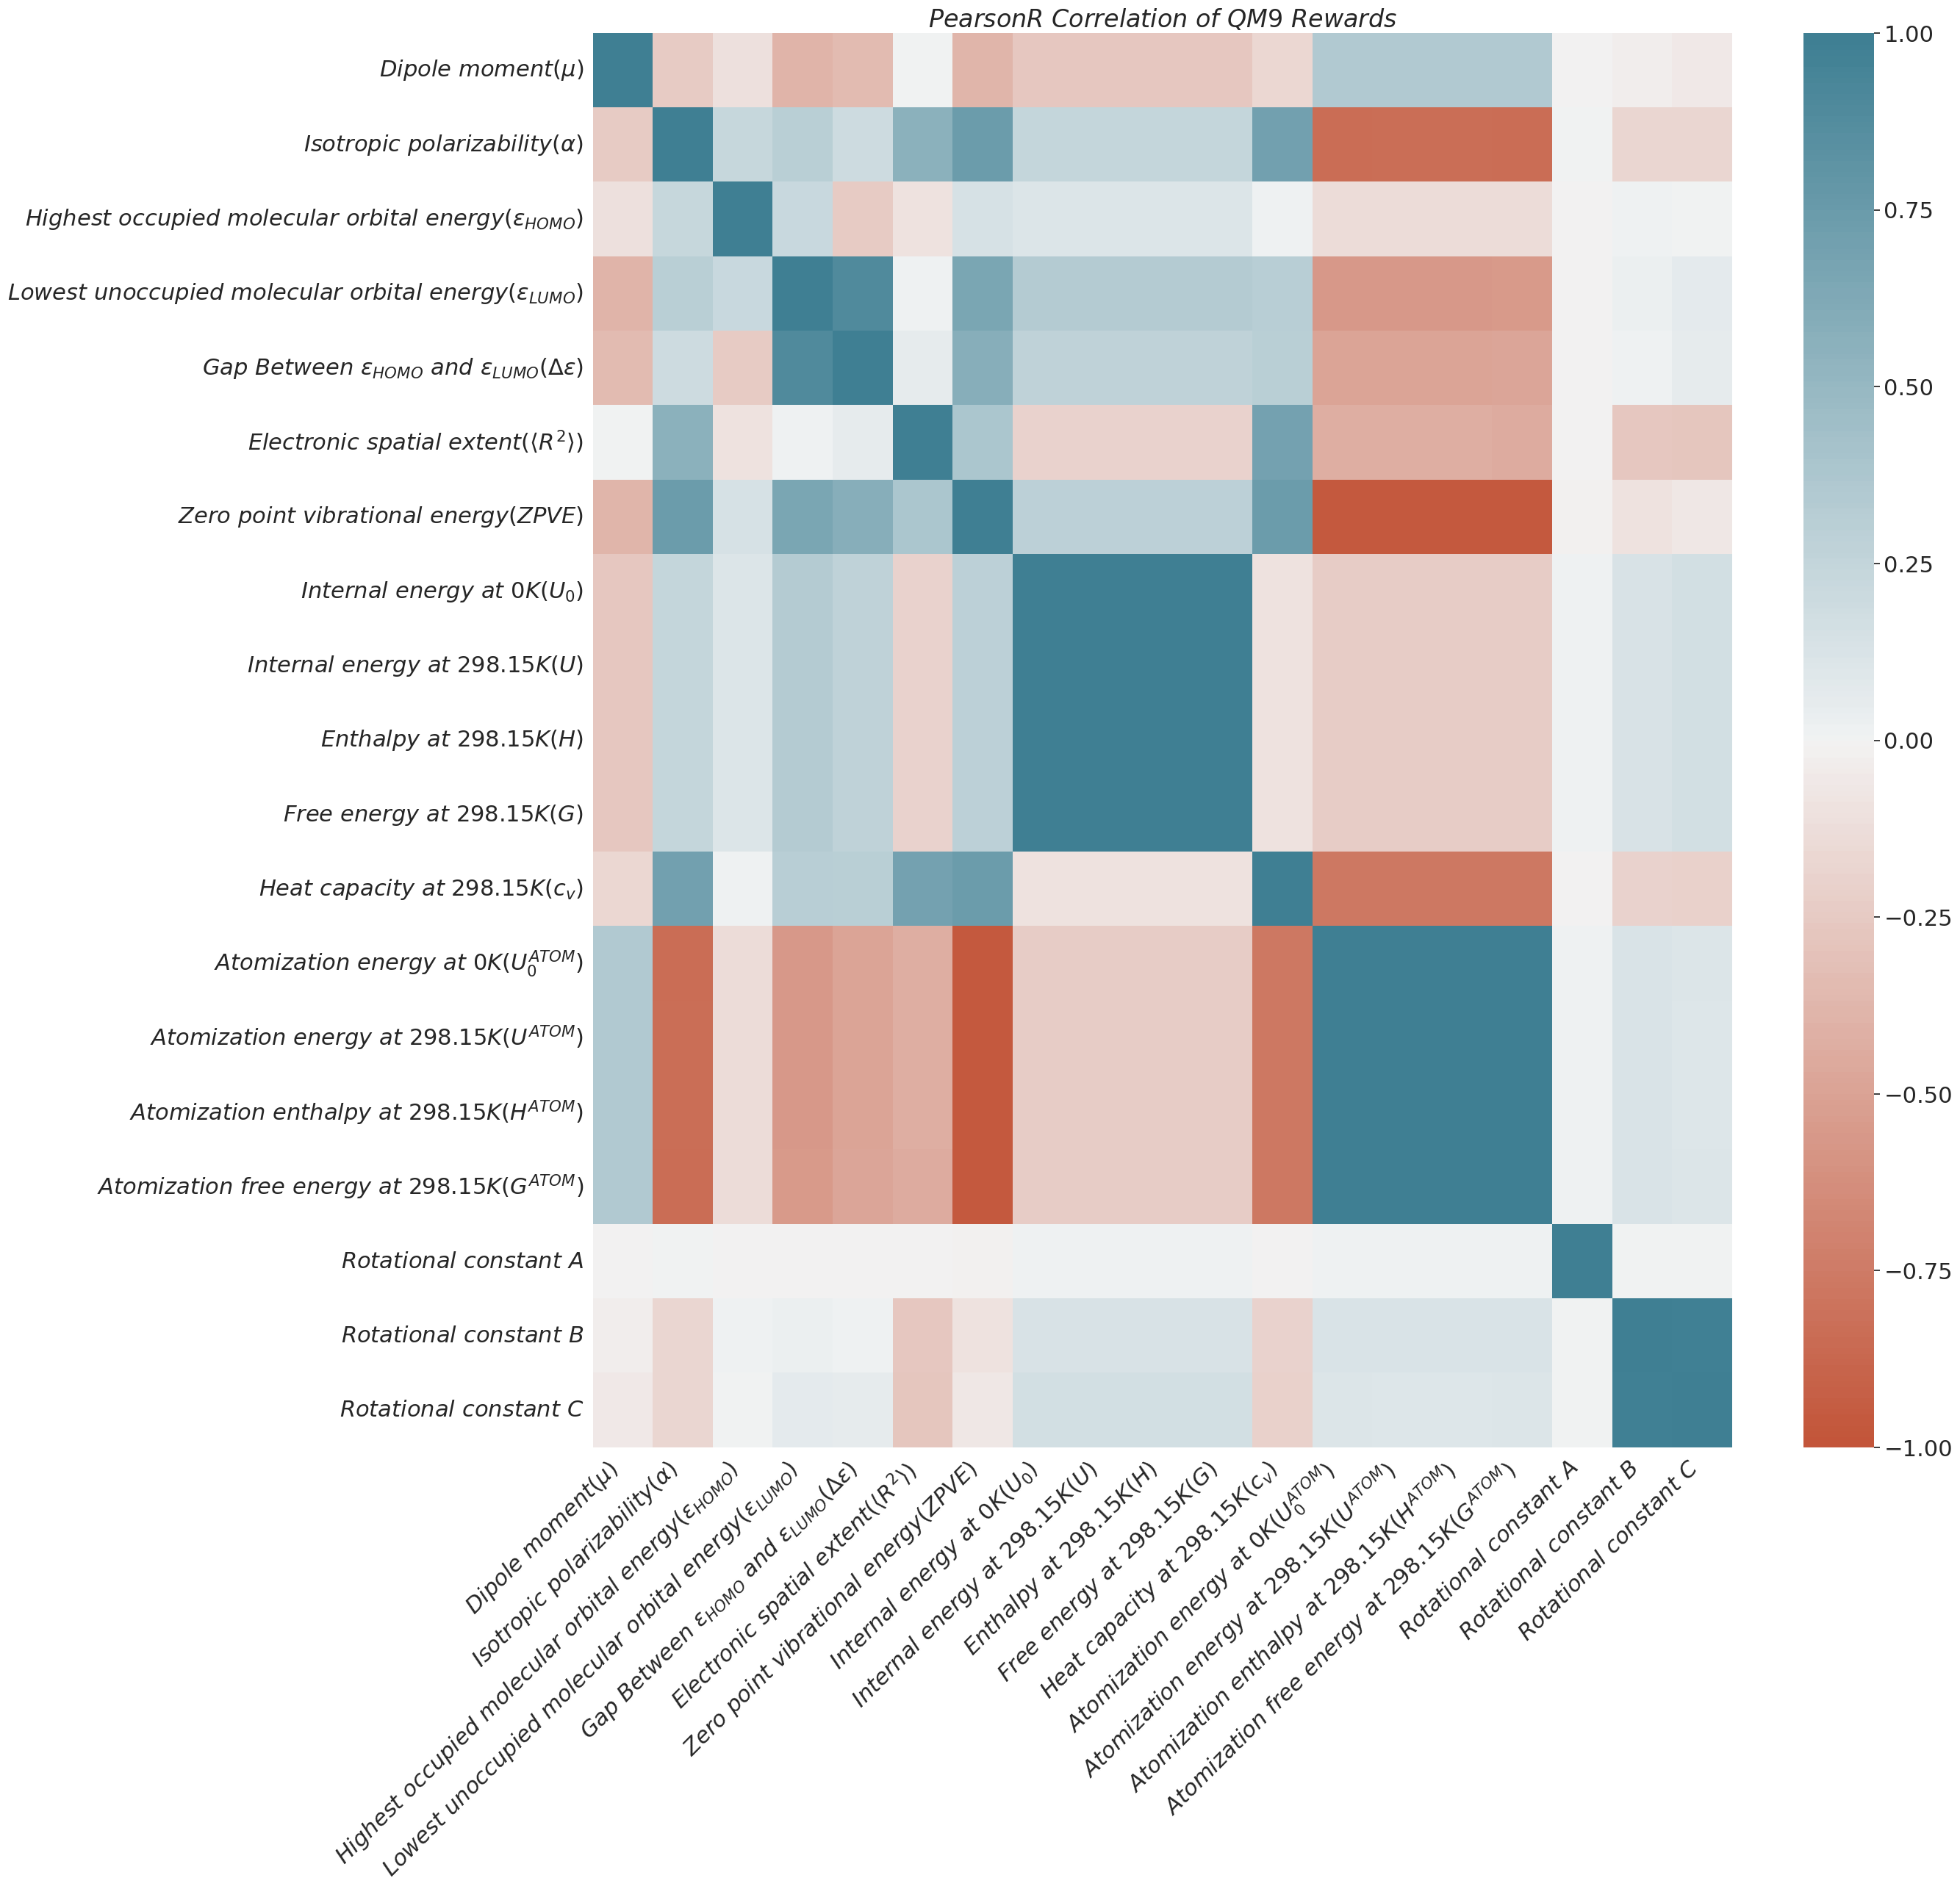

In [4]:
from torch_geometric.loader import DataLoader

BATCH_SIZE = 25 

loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

from sklearn.preprocessing import StandardScaler
import torch
import numpy as np

rewards_all = []

for r in range(19):
    rewards = []
    for i, data in enumerate(loader):
        # Every data instance is an input + label pair
        reward = data.y[:,r].flatten().tolist()
        rewards.extend(reward)
    rewards_all.append(rewards)


rewards_names = [r'$Dipole\ moment(\mu)$',r'$Isotropic\ polarizability(\alpha)$',r'$Highest\ occupied\ molecular\ orbital\ energy(\epsilon_{HOMO})$',
r'$Lowest\ unoccupied\ molecular\ orbital\ energy(\epsilon_{LUMO})$',r'$Gap\ Between\ \epsilon_{HOMO}\ and\ \epsilon_{LUMO}(\Delta \epsilon)$',
r'$Electronic\ spatial\ extent(\langle R^2 \rangle)$',r'$Zero\ point\ vibrational\ energy(ZPVE)$',r'$Internal\ energy\ at\ 0K(U_0)$',r'$Internal\ energy\ at\ 298.15K(U)$',
r'$Enthalpy\ at\ 298.15K(H)$',r'$Free\ energy\ at\ 298.15K(G)$',r'$Heat\ capacity\ at\ 298.15K(c_{v})$',r'$Atomization\ energy\ at\ 0K(U_0^{ATOM})$',
r'$Atomization\ energy\ at\ 298.15K(U^{ATOM})$',r'$Atomization\ enthalpy\ at\ 298.15K(H^{ATOM})$',r'$Atomization\ free\ energy\ at\ 298.15K(G^{ATOM})$',
r'$Rotational\ constant\ A$',r'$Rotational\ constant\ B$',r'$Rotational\ constant\ C$']


from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import textwrap
import pandas as pd
import subprocess
import os


corr_mat = np.zeros((19,19))

for i in range(19):
    for j in range(19):
        corr_mat[i,j] = pearsonr(rewards_all[i], rewards_all[j])[0]


plt.figure(figsize=(25, 25), facecolor='w', edgecolor='k')
sns.set(font_scale=2)
hm = sns.heatmap(corr_mat,vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            #cmap = 'coolwarm',
            annot=False,
            xticklabels = rewards_names,
            yticklabels = rewards_names,)
hm.set_xticklabels(hm.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title(r'$PearsonR\ Correlation\ of\ QM9\ Rewards$')

plt.savefig('heatmap.svg', format='svg')
command = ['svg42pdf', os.path.join(os.getcwd(), 'heatmap.svg'), 'heatmap.pdf']
subprocess.run(command, stderr=subprocess.PIPE, text=True)



In [15]:
#NORMALIZE REWEARDS
from torch_geometric.loader import DataLoader

BATCH_SIZE = 25 

loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

from sklearn.preprocessing import StandardScaler
import torch

rewards = []

for i, data in enumerate(loader):
        # Every data instance is an input + label pair
        reward = data.y[:,1].flatten().tolist()
        rewards.extend(reward)

#feature_tensor = torch.tensor(features).reshape((16000, 15))
reward_tensor = torch.tensor(rewards).flatten().reshape((-1,1))
print(reward_tensor.shape)
train_scaler = StandardScaler()
norm_rewards = train_scaler.fit_transform(reward_tensor)
print('Mean:',train_scaler.mean_, 'Var:',train_scaler.var_)
print(len(norm_rewards))
print(norm_rewards[0])

torch.Size([130831, 1])
Mean: [75.28118504] Var: [66.81099719]
130831
[0.1637938]


In [16]:
norm_rewards_list = []

for i in range(len(norm_rewards)):
    norm_rewards_list.append([norm_rewards[i][0]])

In [17]:
print(norm_rewards_list[0])
print(type(norm_rewards_list[0][0]))

[0.16379380475807365]
<class 'numpy.float64'>


In [9]:
import time

t0 = time.time()
padded =False
features_list = []
connections_list = []
rewards_list = norm_rewards_list
num_nodes_list = []

for ix in range(130831):
    #print(ix)
    features = dataset[ix].x
    pos = dataset[ix].pos
    atomic_num = dataset[ix].z[:,None] #ADD THESE 4 ADDITIONAL FEATURES!!!!!
    #overall_features = torch.cat((features, pos, atomic_num), 1).tolist()
    features_list.append(torch.cat((features, pos, atomic_num), 1).tolist())
    connections_list.append(convert_to_adj(torch.transpose(dataset[ix].edge_index,0,1), dataset[ix].z.shape[0]).tolist())
    #num_nodes_list.append(len(connections_list[-1]))
    #rewards_list.append([dataset[ix].y[0,0].tolist()]) 

total_time = (time.time() - t0) / 60

#max_num_nodes = max(num_nodes_list)

data_config = {
    'env_seed': 875, #OBSOLETE
    'seeddata_size': 5, #OBSOLETE
    'padded': padded,
    #'num_nodes': 80, #OBSOLETE, VARYING NUM_NODES?????
    'feat_dim': 15, 
    'num_mlp_layers': 4, 
    'noise_var': 0.0001, #OBSOLETE
    #'edge_prob': 0.2, #OBSOLETE
    #'sampling_mode': 'binomial', #OBSOLETE
    'dataset_size': 130831}

dataset = {
    'features': features_list, 
    'connections': connections_list, 
    'rewards': rewards_list}

results_dict = {
        'params': data_config,
        'dataset': dataset,
        'duration_total': total_time
    }


In [15]:
print(results_dict['params']['dataset_size'])

130831


In [12]:
print(type(features_list[0]))
print(type(features_list))
print(features_list[0])
print(type(features_list[0][0]))
#print(max_num_nodes)

print(type(rewards_list[0]))
print(type(rewards_list))
print(rewards_list[0])
print(type(rewards_list[0][0]))

<class 'list'>
<class 'list'>
[[0.0, 1.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 4.0, -0.01269999984651804, 1.085800051689148, 0.00800000037997961, 6.0], [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002199999988079071, -0.006000000052154064, 0.0020000000949949026, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0117000341415405, 1.4637999534606934, 0.0003000000142492354, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.5407999753952026, 1.4474999904632568, -0.8766000270843506, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.5238000154495239, 1.4378999471664429, 0.9064000248908997, 1.0]]
<class 'list'>
<class 'list'>
<class 'list'>
[-1.1982603924038548]
<class 'numpy.float64'>


In [ ]:
''' SUBSAMPLING STEP IF NEED BE'''

#from numpy import random

#subsampling_ratio = 0.01
#n_samples = int(130831*subsampling_ratio)


from sklearn.model_selection import train_test_split
subsampling_ratio = 0.01

features_removed, features_taken, connections_removed, connections_taken, rewards_removed, rewards_taken = train_test_split(features_list, connections_list, rewards_list, test_size=subsampling_ratio, random_state=42)

print('feat_rem:', len(features_removed))
print('feat_taken:', len(features_taken))
print('conn_rem: ',len(connections_removed)) 
print('conn_taken: ',len(connections_taken)) 
print('rew_rem: ',len(rewards_removed)) 
print('rew_taken: ',len(rewards_taken))

data_config = {
    'env_seed': 875, #OBSOLETE
    'seeddata_size': 5, #OBSOLETE
    'padded': True,
    'num_nodes': MAX_NUM_NODES, #OBSOLETE, VARYING NUM_NODES?????
    'feat_dim': 11, 
    'num_mlp_layers': 2, 
    'noise_var': 0.0001, #OBSOLETE
    #'edge_prob': 0.2, #OBSOLETE
    #'sampling_mode': 'binomial', #OBSOLETE
    'dataset_size': len(features_taken)}

dataset = {
    'features': features_taken, 
    'connections': connections_taken, 
    'rewards': rewards_taken}

results_dict = {
        'params': data_config,
        'dataset': dataset,
        'duration_total': total_time
    }

In [ ]:
''' COMPLETE ADJ AND FEAT MATRICES TO MAX_NUM_NODES SIZE IF NEED BE 
IF YOU READ DATA IN THIS FORMAT, HACE TO SET NUM_NODES=29'''


def adj_pad(adj_mat):
   return torch.nn.functional.pad(adj_mat,pad=(0,MAX_NUM_NODES-len(adj_mat),0,MAX_NUM_NODES-len(adj_mat)))

def feat_pad(feat_mat):
   return torch.nn.functional.pad(feat_mat,pad=(0,0,0,MAX_NUM_NODES-len(feat_mat)))
   
import time

padded = True

t0 = time.time()

features_list = []
connections_list = []
rewards_list = []
#num_nodes_list = []

for ix in range(130831):
    #print(ix)
    features_list.append(feat_pad(dataset[ix].x).tolist())
    connections_list.append(adj_pad(convert_to_adj(torch.transpose(dataset[ix].edge_index,0,1), dataset[ix].z.shape[0])).tolist())
    rewards_list.append([dataset[ix].y[0,0].tolist()]) 
    #num_nodes_list.append(len(connections_list[-1]))

total_time = (time.time() - t0) / 60

#max_num_nodes = max(num_nodes_list)

data_config = {
    'env_seed': 875, #OBSOLETE
    'seeddata_size': 5, #OBSOLETE
    'padded': True,
    'num_nodes': MAX_NUM_NODES, #OBSOLETE, VARYING NUM_NODES?????
    'feat_dim': 11, 
    'num_mlp_layers': 2, 
    'noise_var': 0.0001, #OBSOLETE
    #'edge_prob': 0.2, #OBSOLETE
    #'sampling_mode': 'binomial', #OBSOLETE
    'dataset_size': 130831}

dataset = {
    'features': features_list, 
    'connections': connections_list, 
    'rewards': rewards_list}

results_dict = {
        'params': data_config,
        'dataset': dataset,
        'duration_total': total_time
    }



In [ ]:
index = 890
print('Type:', type(results_dict['dataset']['features']))
print('Num Graphs:', len(results_dict['dataset']['features']))
print('Rows: ',len(results_dict['dataset']['features'][index])) 
print('Columns: ',len(results_dict['dataset']['features'][index][0])) 

print('Type:', type(results_dict['dataset']['connections']))
print('Num Graphs:', len(results_dict['dataset']['connections']))
print('Rows: ',len(results_dict['dataset']['connections'][index])) 
print('Columns: ',len(results_dict['dataset']['connections'][index][0])) 

#For features, Changing num of rows according to num_nodes in each graph
#always 11 columns since num feat is fixed to 11

#For connections, each entrys row and col size changes wrt num_nodes in that graph

In [12]:

import os
import json
import sys
#sys.path.append('/local/bsoyuer/base_code/graph_BO')
sys.path.append('/cluster/scratch/bsoyuer/base_code/graph_BO')
from utils_exp import NumpyArrayEncoder

#BASE_DIR = os.path.dirname('/local/bsoyuer/base_code/graph_BO/')
BASE_DIR = os.path.dirname('/cluster/scratch/bsoyuer/base_code/graph_BO/') #__file__ refers to the filename from which this module
#was loaded, so the base_code/graph_BO dir I suppose
DATA_DIR = os.path.join(BASE_DIR, 'data') #Then, should be base_code/graph_BO/data

exp_result_folder = os.path.join(DATA_DIR, 'QM9DATA')

os.makedirs(exp_result_folder, exist_ok=True)
# hash this to create a name, i.e. as you see 2 lines below, hashing assings a
#unique name to each data object which we use infront of .json when saving
data_hash = str(abs(json.dumps(results_dict['params'], sort_keys=True).__hash__()))
exp_result_file = os.path.join(exp_result_folder, '%s.json' % data_hash)
with open(exp_result_file, 'w') as f:
    json.dump(results_dict, f, indent=4, cls=NumpyArrayEncoder)
print('Dumped results to %s' % exp_result_file) #Dump all datapts in results_dicts store
#as dictionaries to a json file with given hashes.


Dumped results to /cluster/scratch/bsoyuer/base_code/graph_BO/data/QM9DATA/5506441260926908885.json


REWARD SURFACE VISUALIZATION WITH DIMENSION REDUCTION

In [3]:
import numpy as np
import torch

def convert_to_adj(pairs, num_nodes):
   zero = torch.zeros(num_nodes, num_nodes)
   zero[pairs[:,0], pairs[:,1]] = 1 
   return zero

def adj_pad(adj_mat):
   return torch.nn.functional.pad(adj_mat,pad=(0,MAX_NUM_NODES-len(adj_mat),0,MAX_NUM_NODES-len(adj_mat)), value=0)#value=float('nan'))

def feat_pad(feat_mat):
   return torch.nn.functional.pad(feat_mat,pad=(0,0,0,MAX_NUM_NODES-len(feat_mat)), value=0)#value=float('nan'))

def z_pad(feat_mat):
   return torch.nn.functional.pad(feat_mat,pad=(0,MAX_NUM_NODES-len(feat_mat)), value=0)# value=float('nan'))

import time

padded = True

t0 = time.time()

features_list = []
connections_list = []
rewards_list = []
positions_list = []
#num_nodes_list = []

for ix in range(130831):
   #print(ix)
   features_list.append(torch.cat((feat_pad(dataset[ix].x.float()), feat_pad(dataset[ix].pos.float()), z_pad(dataset[ix].z.float())[:,None]), 1).flatten().tolist())
   connections_list.append(adj_pad(convert_to_adj(torch.transpose(dataset[ix].edge_index,0,1), dataset[ix].z.shape[0])).tolist())
   rewards_list.append(dataset[ix].y.tolist()) 
   #num_nodes_list.append(len(connections_list[-1]))

rewards_arr = np.array(rewards_list)
rewards_arr.resize((130831,19))

In [14]:
print(np.corrcoef(np.transpose(rewards_arr)))

[[ 1.00000000e+00 -2.43258063e-01 -1.12569147e-01 -3.95400288e-01
  -3.40138118e-01  5.33826643e-03 -3.82909414e-01 -2.64858171e-01
  -2.64861051e-01 -2.64861050e-01 -2.64856918e-01 -1.70756741e-01
   3.53872255e-01  3.54617882e-01  3.54764096e-01  3.52289542e-01
  -6.26753240e-03 -2.46635008e-02 -4.72718940e-02]
 [-2.43258063e-01  1.00000000e+00  2.41923509e-01  3.06508790e-01
   1.91679985e-01  5.61165830e-01  7.34975639e-01  2.47442374e-01
   2.47461162e-01  2.47461162e-01  2.47417861e-01  7.03260106e-01
  -8.36242403e-01 -8.35427985e-01 -8.35053640e-01 -8.40287099e-01
   4.07217274e-03 -1.74913174e-01 -1.78752705e-01]
 [-1.12569147e-01  2.41923509e-01  1.00000000e+00  2.18802912e-01
  -2.48249507e-01 -9.99064341e-02  1.41592352e-01  1.12220207e-01
   1.12217621e-01  1.12217621e-01  1.12226607e-01  1.20563645e-02
  -1.35067518e-01 -1.35615007e-01 -1.35584400e-01 -1.33891588e-01
  -7.28799316e-04  1.90696690e-02  6.79826336e-03]
 [-3.95400288e-01  3.06508790e-01  2.18802912e-01  1.00

In [8]:
correlations = []

for j in range(19):
    correlations.append(np.dot(np.array(rewards_arr[:,0]), np.array(rewards_arr[:,j]))/np.linalg.norm(rewards_arr[:,0])/np.linalg.norm(rewards_arr[:,j]))

print(correlations)

[1.0000000000000002, 0.8536188621415809, -0.8729882677715719, 0.02552815978111902, 0.8260079666575245, 0.8489176962575272, 0.8100915346618136, -0.8800536057494012, -0.8800538079854173, -0.8800538178774499, -0.8800532488436051, 0.8537805942857886, -0.840359972312214, -0.8402053079185745, -0.8401418617144111, -0.8409004087993498, 0.0016727342746166792, 0.5662502665036847, 0.6055348258659534]


In [22]:

print(features_list[0])
print(len(features_list[0]))
print(len(connections_list[0]))
#print(rewards_arr.shape)

[0.0, 1.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 4.0, -0.01269999984651804, 1.085800051689148, 0.00800000037997961, 6.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002199999988079071, -0.006000000052154064, 0.0020000000949949026, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0117000341415405, 1.4637999534606934, 0.0003000000142492354, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.5407999753952026, 1.4474999904632568, -0.8766000270843506, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.5238000154495239, 1.4378999471664429, 0.9064000248908997, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [15]:
#IMPUTER????

#from sklearn.impute import KNNImputer

#imputer = KNNImputer(n_neighbors=2, weights = 'distance')

#features_list_imputed = imputer.fit_transform(features_list)

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
features_list_imputed = imputer.fit_transform(features_list)



In [23]:


#from sklearn.preprocessing import StandardScaler
#scaled_features_list = StandardScaler().fit_transform(features_list)



UMAP

In [1]:
import umap

reducer = umap.UMAP(n_neighbors=80, min_dist=0.2)
embedding = reducer.fit_transform(features_list)
#embedding = reducer.fit_transform(features_list_imputed)
#embedding = reducer.fit_transform(scaled_features_list)

print(embedding.shape)

'''If you get the numpy 0xe error just rerun after it terminates'''



/cluster/project/krause/bsoyuer/miniconda3/envs/graphbo/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-18 00:14:59.275524: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-18 00:14:59.448775: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-18 00:14:59.449425: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


RuntimeError: module compiled against API version 0xf but this version of numpy is 0xd

NameError: name 'features_list' is not defined

TSNE

In [26]:
#from sklearn.manifold import TSNE

#embedding = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=5).fit_transform(features_list)

[127706 119401 127707  98491  95578  54821  95596  99804 119658 120899]


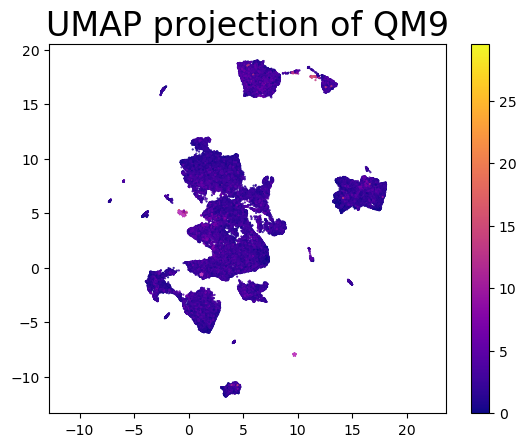

In [8]:
import matplotlib.pyplot as plt

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=rewards_arr[:,0],
    cmap='plasma',
    s = 1/4)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of QM9', fontsize=24);
plt.colorbar()

#Find K largest rewards
K = 10
max_indices = np.argsort(rewards_arr[:,0])[-K:]
print(max_indices)
max_embeddings = embedding[max_indices,:]
plt.scatter(max_embeddings[:, 0],
    max_embeddings[:, 1], c='#BF40BF', s=5, marker="*")

0
[127706 119401 127707  98491  95578  54821  95596  99804 119658 120899]
1
[ 95590 114701  32224  51297  95591  51296  54821  95578  51295 120899]
2
[127706 127707  22028  31422  31472  29882  28732  22893 120899  45472]
3
[ 2352  3464   685 76706 37237   705  3483   101     0   180]
4
[    12  23348   4159   4155      6    817 130606  23349      0    180]
5
[121027 121032 121021 121019 121031 121018 121036 121017 121016 121015]
6
[116298  97834 115918 120908  98938 116402 119916 119787 121015 100382]
7
[15  8  7  5  4  6  3  2  1  0]
8
[15  8  7  5  4  6  3  2  1  0]
9
[15  8  7  5  4  6  3  2  1  0]
10
[15  8  7  5  4  6  3  2  1  0]
11
[ 58744 115837  98705 115514  98335  98024  56618  56534  55967  98023]
12
[ 24   7 180 173   0   3   5   4   1   2]
13
[ 24   7 180 173   0   3   5   4   1   2]
14
[ 24   7 180 173   0   3   5   4   1   2]
15
[ 24   7 180 173   0   3   5   4   1   2]
16
[51296 51295  2585   111     8     5     1     2 14240   474]
17
[ 6 15 16  7  3  5  4  0  1  2]


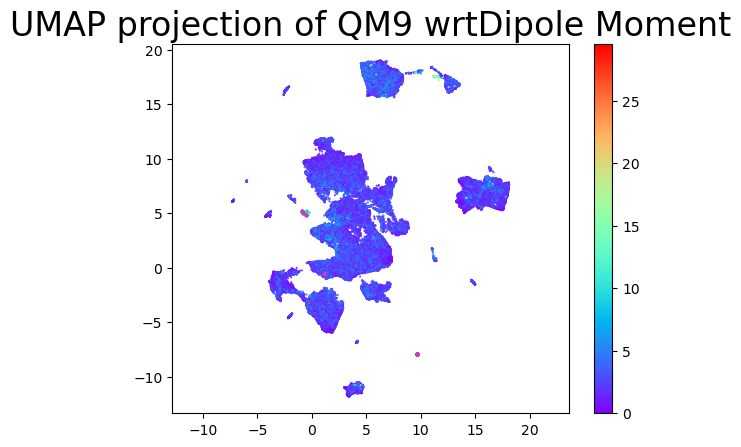

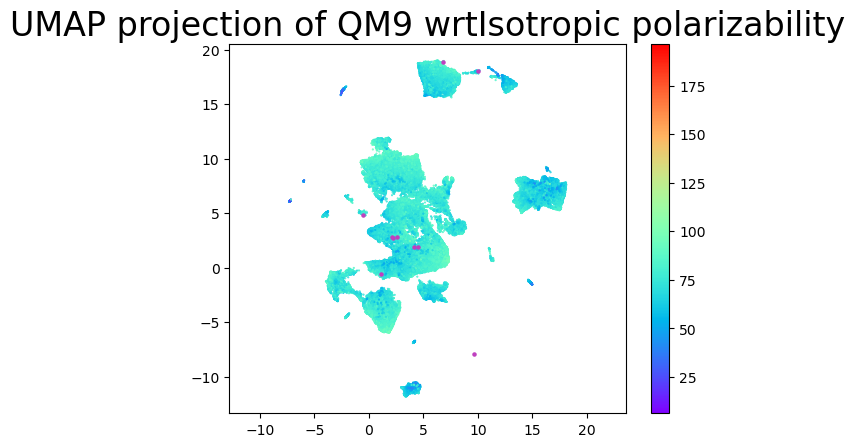

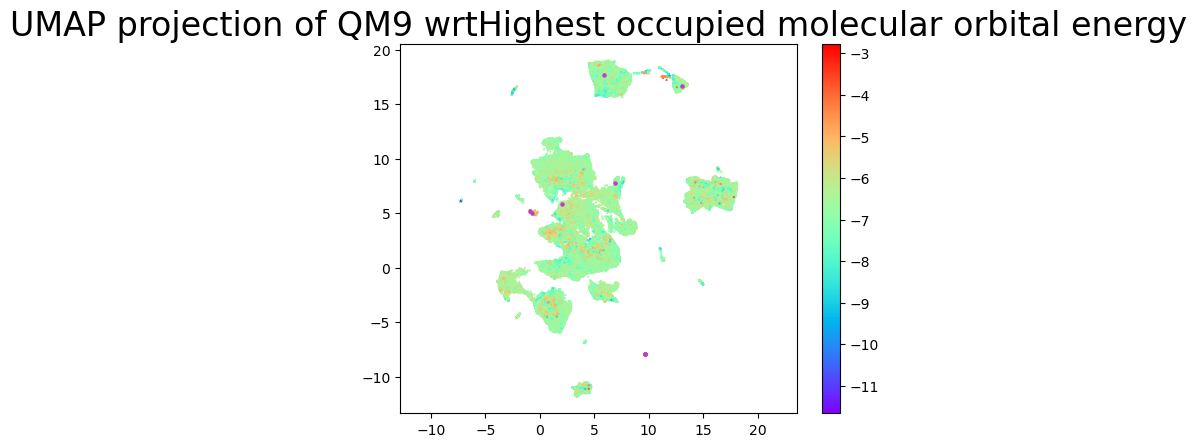

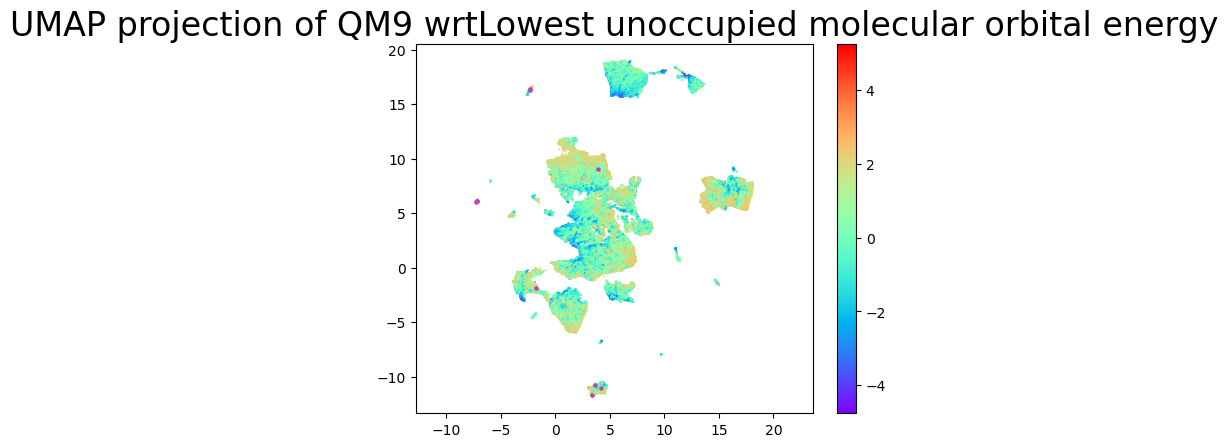

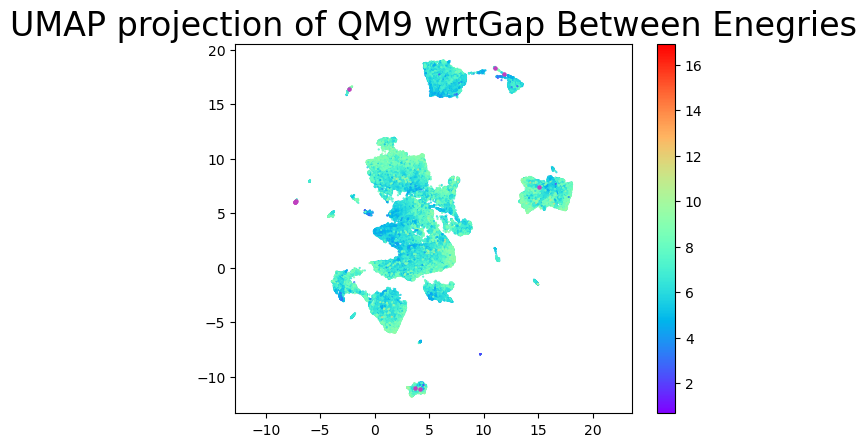

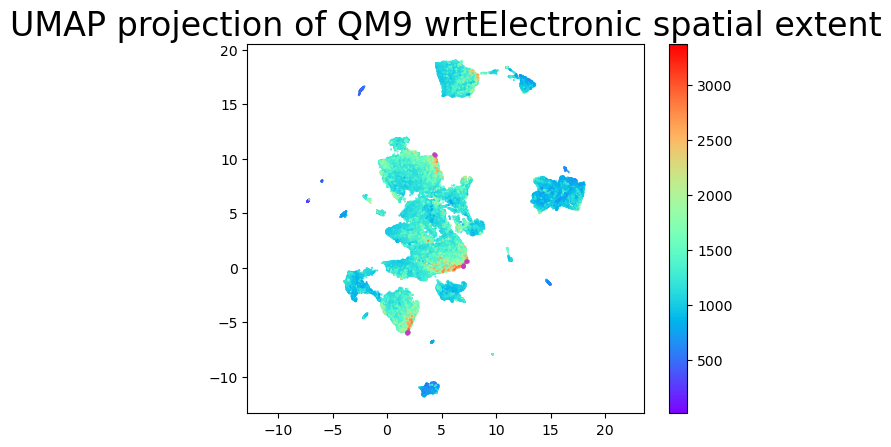

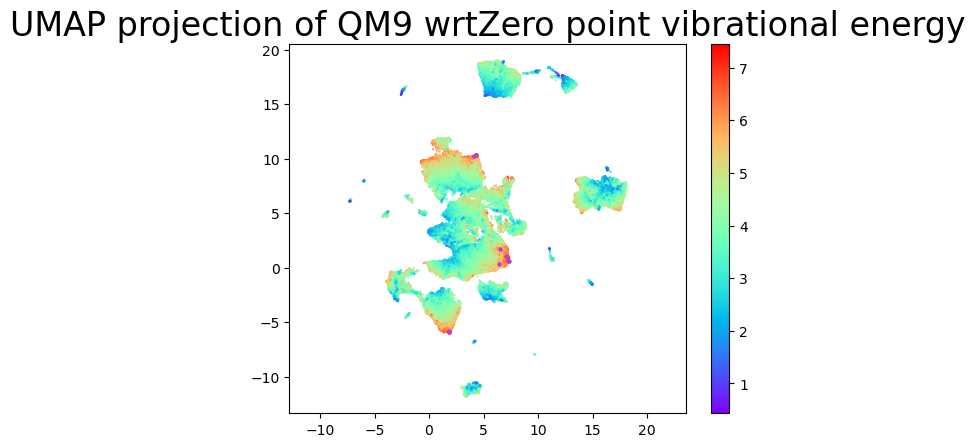

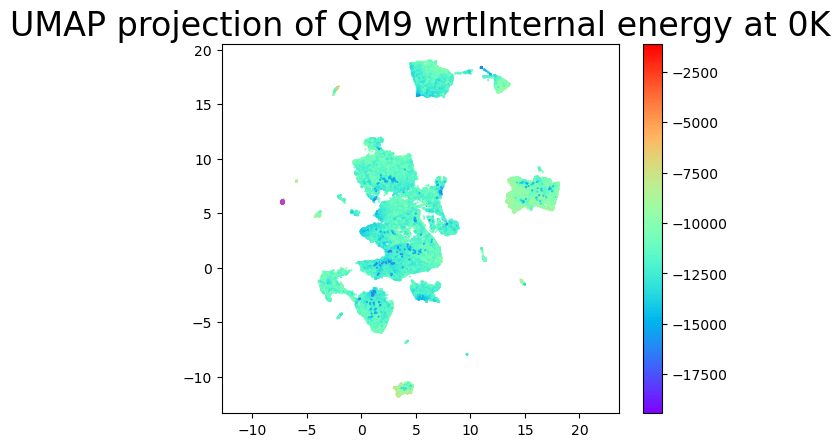

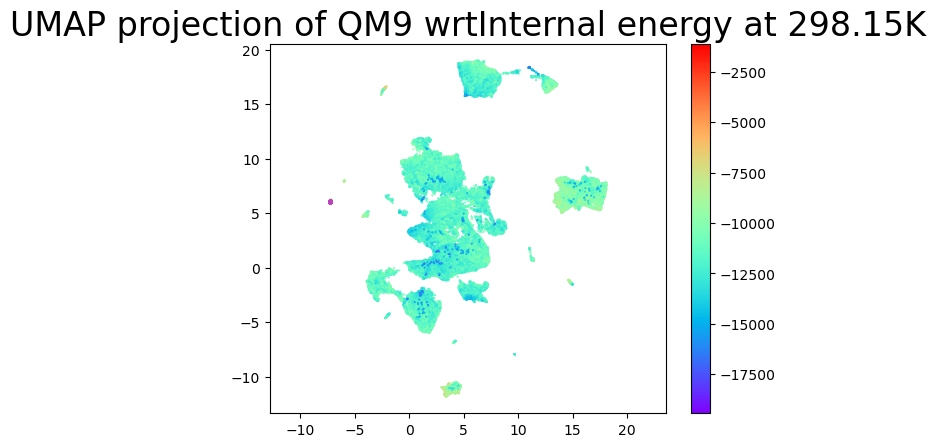

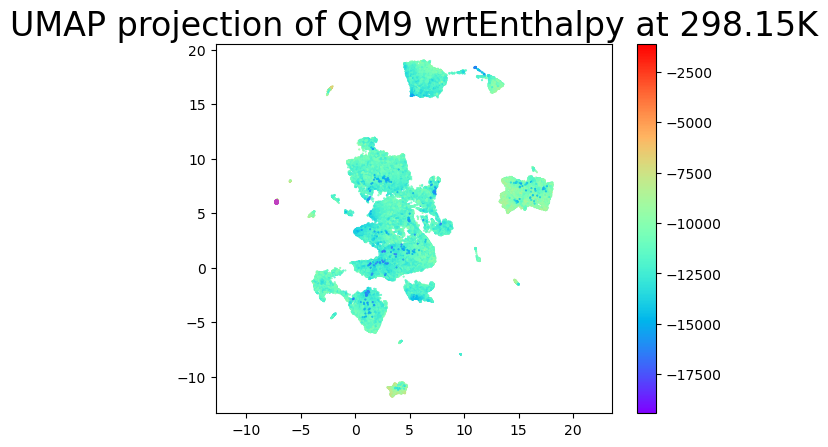

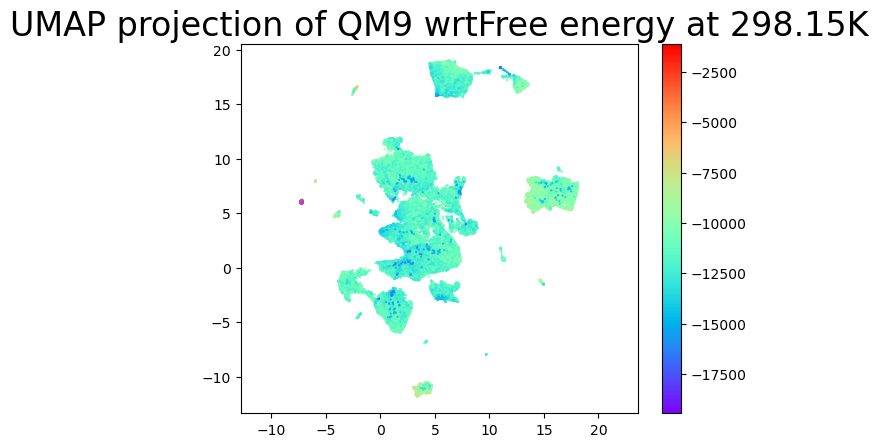

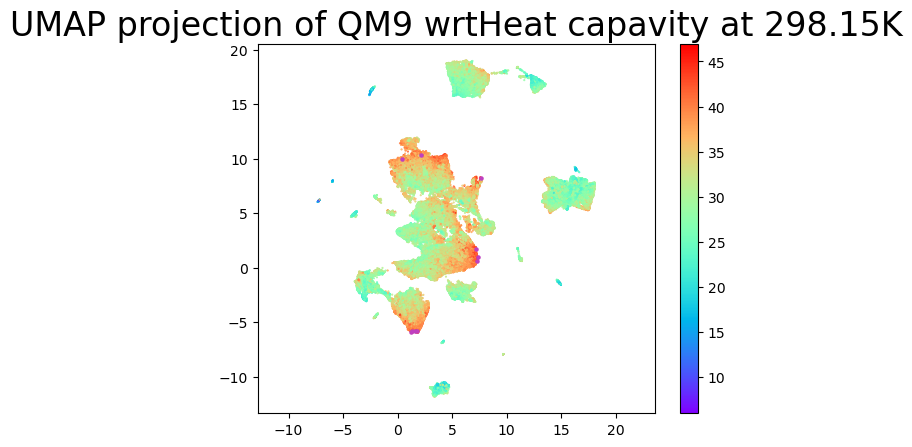

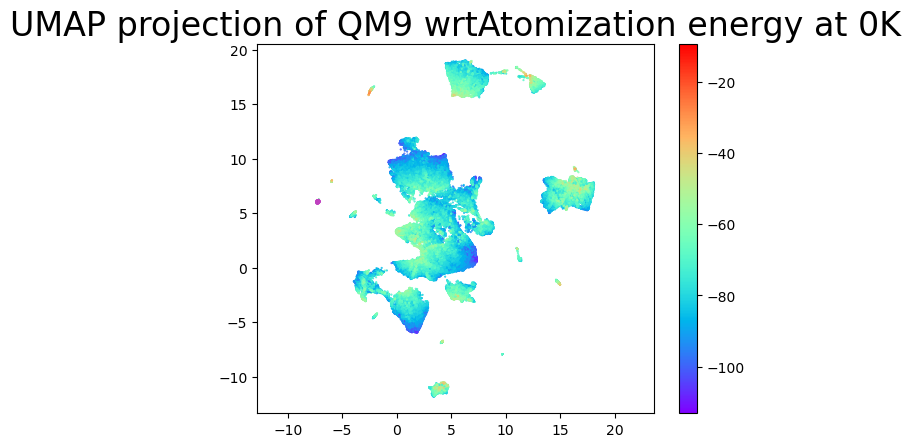

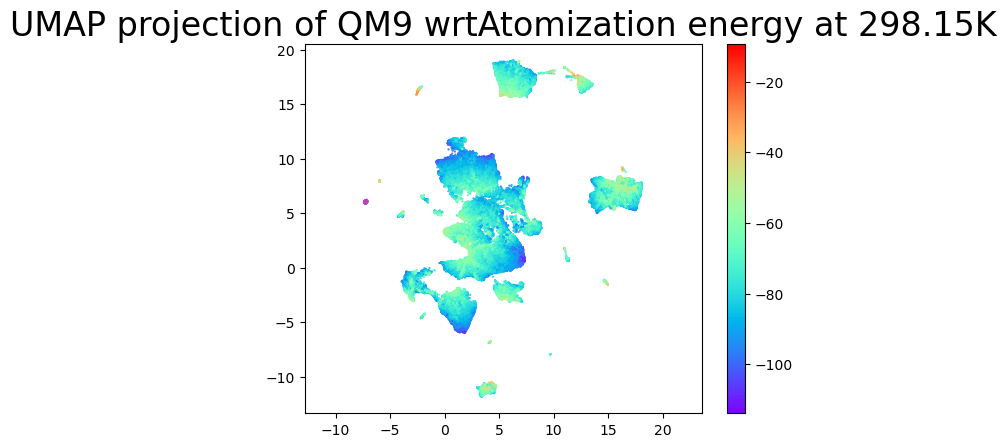

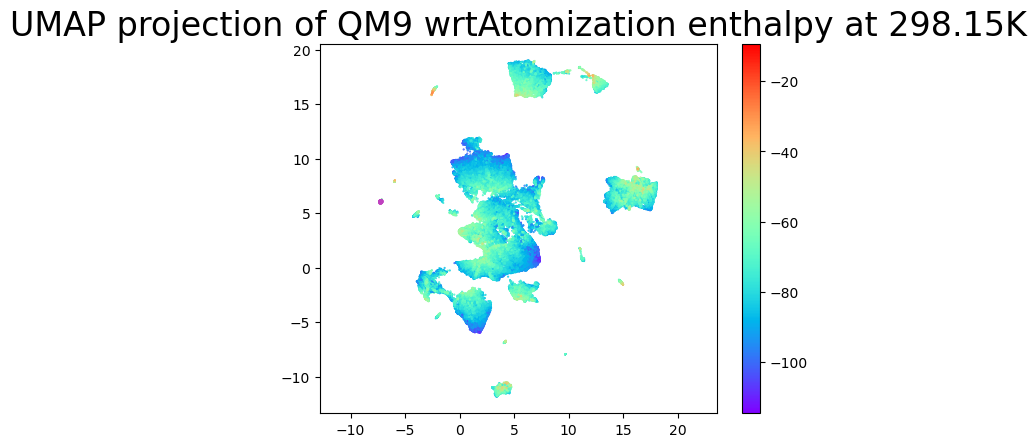

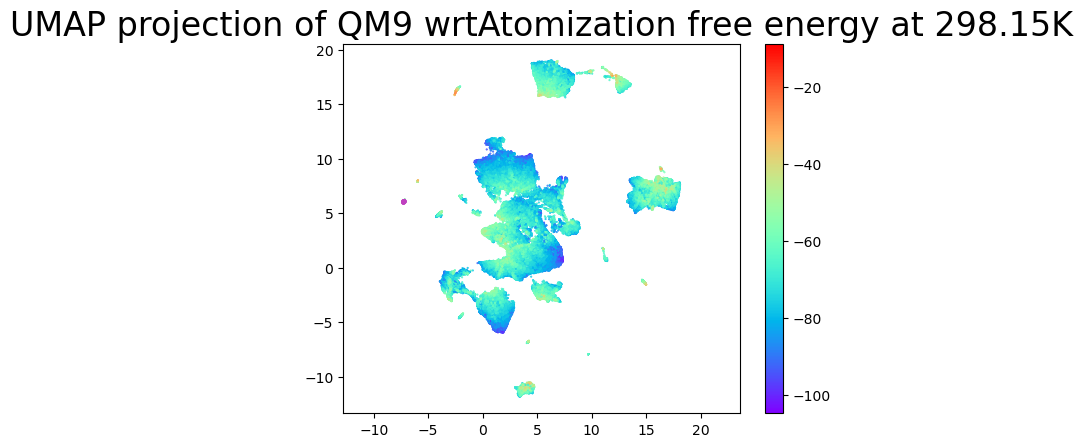

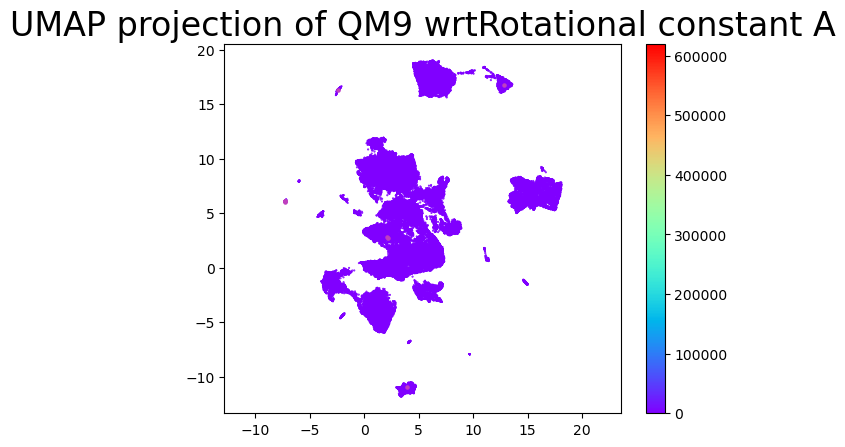

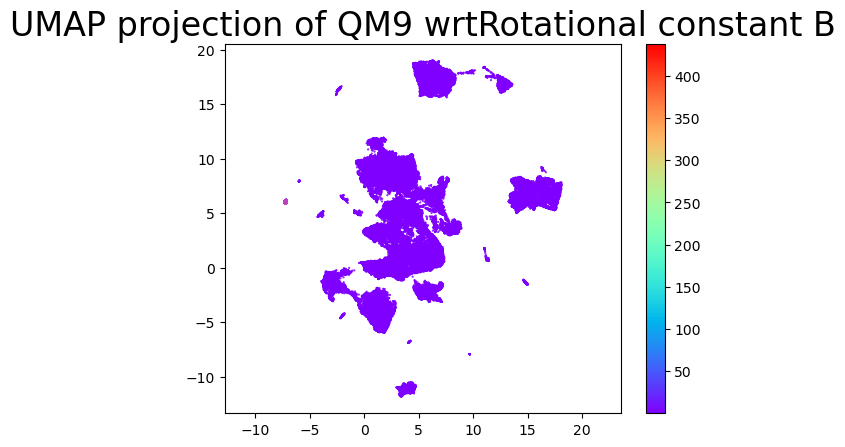

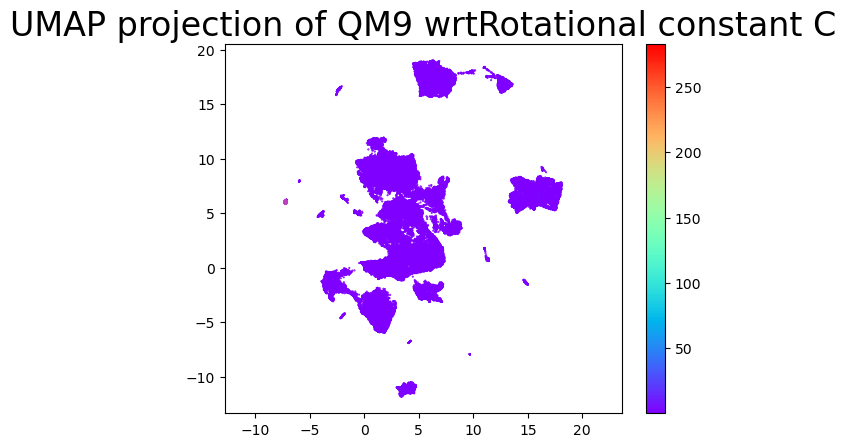

In [13]:
rewards_names = ['Dipole Moment','Isotropic polarizability','Highest occupied molecular orbital energy',
'Lowest unoccupied molecular orbital energy','Gap Between Enegries','Electronic spatial extent',
'Zero point vibrational energy','Internal energy at 0K','Internal energy at 298.15K',
'Enthalpy at 298.15K','Free energy at 298.15K','Heat capavity at 298.15K','Atomization energy at 0K',
'Atomization energy at 298.15K','Atomization enthalpy at 298.15K','Atomization free energy at 298.15K',
'Rotational constant A','Rotational constant B','Rotational constant C']

#rint(len(rewards_names))
import umap
import matplotlib.pyplot as plt

for reward_ix in range(len(rewards_names)):

    print(reward_ix)
    
    plt.figure()
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=rewards_arr[:,reward_ix],
        cmap='rainbow',
        s = 1/4)
    plt.colorbar()
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('UMAP projection of QM9 wrt'+rewards_names[reward_ix], fontsize=24);

    #Find K largest rewards
    K = 10
    max_indices = np.argsort(rewards_arr[:,reward_ix])[-K:]
    print(max_indices)
    max_embeddings = embedding[max_indices,:]
    plt.scatter(max_embeddings[:, 0],
    max_embeddings[:, 1], c='#BF40BF', s=5)
    plt.savefig('./qm9_rewards/'+rewards_names[reward_ix]+'.jpg')